In [25]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib as mplt
from datetime import datetime

In [26]:
#不显示warn信息
import warnings
import missingno as msno
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [31]:
def bulid_line_graph(x,y,x_lable,y_lable,title,marker):
    if isinstance(x[0], str):
        x_str = x
        x = range(len(x))
        plt.xticks(x, x_str, rotation=45)
    plt.xlabel(x_lable,fontsize=20)
    plt.ylabel(y_lable,fontsize=20)
    plt.title(title,fontsize=25)
    plt.plot(x,y,marker=marker)
    plt.show()

In [33]:
def build_scatter_graph(x,y,x_lable,y_lable,title):

    if isinstance(x[0], str):
        x_str = x
        x = range(len(x))
        plt.xticks(x, x_str, rotation=45)
    
    plt.scatter(x,y)
    plt.xlabel(x_lable)
    plt.ylabel(y_lable)
    plt.title(title)
    plt.show()

#### 梳理可用特征
接下来我们梳理数据中的可用的特征
* 由上面的**热力图**，我们很容易发现**temp与atemp**有多重共线性，所以保留temp
* **注册用户与临时用户**与count有很强的相关性，关于此处有认为是数据泄露，也有人认为此处不，使用这两个特征将数据分开训练，而后再加和。
* 关于风速在热力图中，我们发现其与count不是有很强的相关性。
* **湿度**特征是与其负相关
* 这里对于**时间**的处理，是非常值得思考的，为什么没有在热力图中显示？
   * 数据被切分为年、月、日、工作日、周末、小时扩展特征(下图为时间特征常用的处理方式)
   * 时间序列预测？

![](./时间特征.png)

#### 风速的预测
风速特征处理
* 在28个风级，分别求和，然后做出折线图，我们来查看一下<br>
https://www.kaggle.com/c/bike-sharing-demand/discussion/10431

In [28]:
dataTrain = pd.read_csv('./data/train.csv')
dataTest = pd.read_csv('./data/test.csv')

In [60]:
data = dataTrain.append(dataTest)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)
data['month'] = pd.DatetimeIndex(data.datetime).month
data['day'] = pd.DatetimeIndex(data.datetime).dayofweek
data['hour'] = pd.DatetimeIndex(data.datetime).hour
data['year'] = pd.DatetimeIndex(data.datetime).year
data['date'] = pd.DatetimeIndex(data.datetime).date

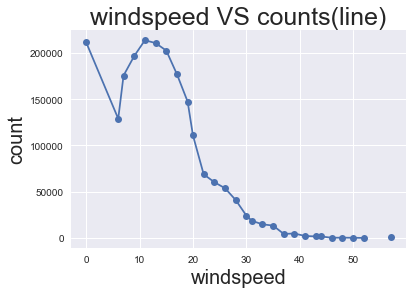

In [32]:
windspeed_data = data[['windspeed','count']].groupby('windspeed').sum()
y = windspeed_data['count'].values
bulid_line_graph(windspeed_data.index,y,'windspeed','count','windspeed VS counts(line)','o')

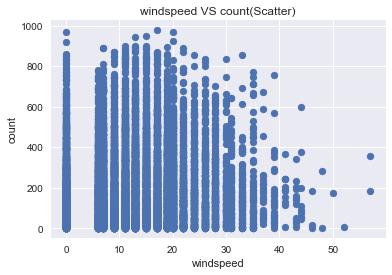

In [34]:
build_scatter_graph(data.windspeed.values,data['count'].values,'windspeed','count','windspeed VS count(Scatter)')

### RandomForestRegressor 预测风速
* 1.对于风速认为[0,6)级是缺失值
* 2.缺失值常用的处理手段：
   * 粗暴删除
   * 填充0，平均值，众数 带来noise
   * 使用RandomForestRegressor预估填充 (偏差)bais
* 选择标准
   * 业务上来确定，这些缺失值是怎么来的，是该样本来就没有，还是没有记录
* 例1：比如没有孩子的人，年龄最大的孩子的身高，该值的缺失就是因为没有
* 例2：但是在统计西瓜的数据集中，西瓜颜色的缺失。<br>
参考链接https://www.kaggle.com/c/bike-sharing-demand/discussion/10431   <br>
参考链接https://www.kaggle.com/rtatman/data-cleaning-challenge-handling-missing-values?utm_medium=email&utm_source=mailchimp&utm_campaign=5DDC-data-cleaning

In [35]:
from sklearn.ensemble import RandomForestRegressor
dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]
rfModel_wind = RandomForestRegressor()
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])
wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0["windspeed"] = wind0Values
data = dataWindNot0.append(dataWind0)

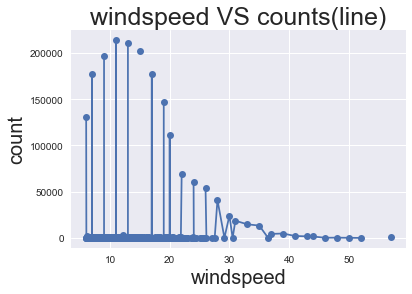

In [37]:
windspeed_data1 = data[['windspeed','count']].groupby('windspeed').sum()
y = windspeed_data1['count'].values
bulid_line_graph(windspeed_data1.index,y,'windspeed','count','windspeed VS counts(line)','o')

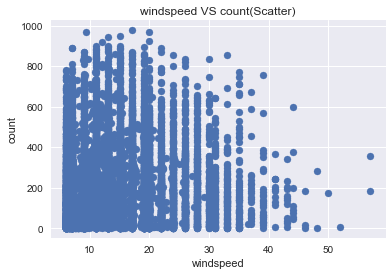

In [38]:
build_scatter_graph(data.windspeed.values,data['count'].values,'windspeed','count','windspeed VS count(Scatter)')

#### 对特征划分

In [53]:
categoricalFeatureNames = ["season","holiday","workingday","weather","day","month","year","hour"]#
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered"]

In [54]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

In [64]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
yLablesRegistered = dataTrain["registered"]
yLablesCasual = dataTrain["casual"]

In [65]:
dataTrain  = dataTrain.drop(dropFeatures,axis=1)
dataTest  = dataTest.drop(dropFeatures,axis=1)

In [66]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

#### LinearRegression

In [67]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
yLabelsLog = np.log1p(yLabels)
lModel.fit(X = dataTrain,y = yLabelsLog)

# Make predictions
preds = lModel.predict(X= dataTrain)
print ("RMSLE Value For Linear Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Linear Regression:  0.97802020075


{'alpha': 0.1, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.978020185667


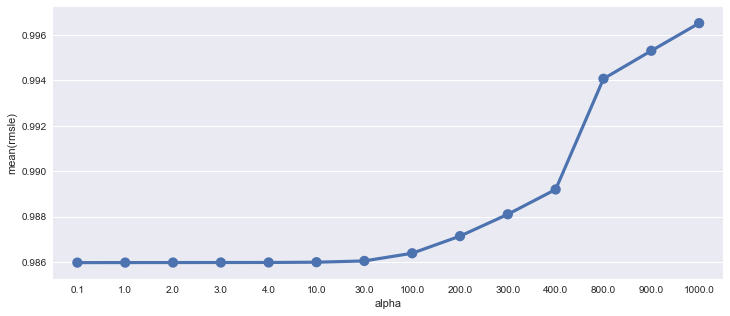

In [69]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)
yLabelsLog = np.log1p(yLabels)
grid_ridge_m.fit( dataTrain, yLabelsLog )
preds = grid_ridge_m.predict(X= dataTrain)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_ridge_m.grid_scores_)
df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

{'alpha': 0.0050000000000000001, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.97815668848


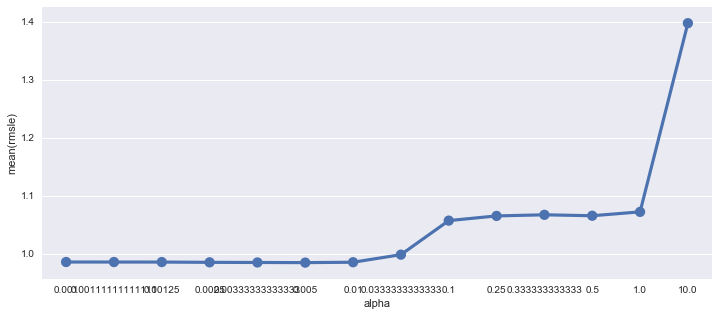

In [71]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
yLabelsLog = np.log1p(yLabels)
grid_lasso_m.fit( dataTrain, yLabelsLog )
preds = grid_lasso_m.predict(X= dataTrain)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_lasso_m.grid_scores_)
df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

#### Ensemble Models - Random Forest

In [72]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)
yLabelsLog = np.log1p(yLabels)
rfModel.fit(dataTrain,yLabelsLog)
preds = rfModel.predict(X= dataTrain)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Random Forest:  0.103741764764


In [73]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01); ### Test 0.41
yLabelsLog = np.log1p(yLabels)
gbm.fit(dataTrain,yLabelsLog)
preds = gbm.predict(X= dataTrain)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Gradient Boost:  0.189119198588


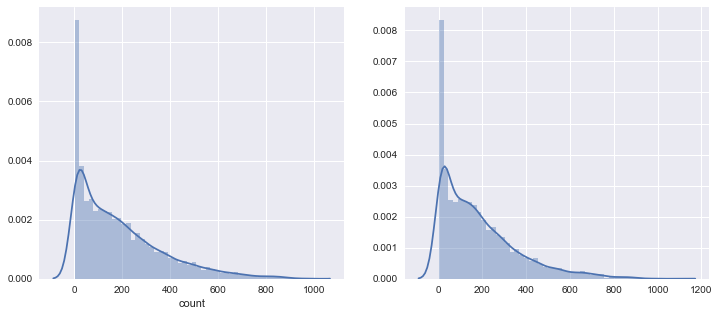

In [75]:
predsTest = gbm.predict(X= dataTest)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(yLabels,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [76]:
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(predsTest)]
    })
submission.to_csv('bike_predictions_gbm_separate_without_fe.csv', index=False)